In [ ]:
import typing
import logging

import cupy as cp

from IPython.display import Image

from morpheus.config import Config
from morpheus.pipeline import LinearPipeline

from morpheus.stages.general.monitor_stage import MonitorStage
from morpheus.stages.input.file_source_stage import FileSourceStage
from morpheus.stages.preprocess.deserialize_stage import DeserializeStage
from morpheus.stages.output.in_memory_sink_stage import InMemorySinkStage
from morpheus.stages.inference.identity_inference_stage import IdentityInferenceStage

from morpheus.pipeline.pass_thru_type_mixin import PassThruTypeMixin
from morpheus.pipeline.execution_mode_mixins import GpuAndCpuMixin
from morpheus.pipeline.single_port_stage import SinglePortStage

from morpheus.messages import ControlMessage
from morpheus.messages import TensorMemory

from morpheus.utils.logger import configure_logging, reset_logging

import mrc
from mrc.core import operators as ops

In [ ]:
class AddTensors(PassThruTypeMixin, GpuAndCpuMixin, SinglePortStage):

    @property
    def name(self) -> str:
        return "add-tensors"

    def accepted_types(self) -> tuple:
        return (ControlMessage, )

    def supports_cpp_node(self) -> bool:
        return False

    def on_data(self, message: ControlMessage) -> ControlMessage:
        
        # Here, we collect attributes for our simulated inference tensor data
        count, ncols = message.payload().get_data().shape
        
        # Here we create fake seq_ids for our no-op inference following the setup strategy from the previous notebook.
        seq_ids = cp.zeros((count, 3), dtype=cp.uint32)
        seq_ids[:, 0] = cp.arange(0, count, dtype=cp.uint32)        
        
        # Here we create some fake data for our no-op inference
        data = cp.zeros(shape=(count, ncols), dtype=cp.float32)
        
        # Initialize our TensorMemory object
        tensor_memory = TensorMemory(count=count)
        # add our tensors to the TensorMemory object
        tensor_memory.set_tensor("seq_ids", seq_ids)
        tensor_memory.set_tensor("input__0", data)

        # Set the tensor memory in the ControlMessage
        message.tensors(tensor_memory)

        return message

    def _build_single(self, builder: mrc.Builder, input_node: mrc.SegmentObject) -> mrc.SegmentObject:
        node = builder.make_node(self.unique_name, ops.map(self.on_data))
        builder.make_edge(input_node, node)

        return node

In [ ]:
input_file = 'data/simple_user_log.jsonlines'

In [ ]:
config = Config(feature_length=6)

In [ ]:
pipeline = LinearPipeline(config)

pipeline.set_source(FileSourceStage(config, filename=input_file, iterative=False, repeat=100))
pipeline.add_stage(DeserializeStage(config))

pipeline.add_stage(AddTensors(config))

pipeline.add_stage(IdentityInferenceStage(config))

in_mem_sink = pipeline.add_stage(InMemorySinkStage(config))

pipeline.add_stage(MonitorStage(config, description="Pipeline throughput"))

<monitor-5; MonitorStage(description=Pipeline throughput, smoothing=0.05, unit=messages, delayed_start=False, determine_count_fn=None, log_level=LogLevels.INFO)>

In [ ]:
pipeline.build()

In [ ]:
viz_file = './pipeline_visualizations/no-op-inference.png'
pipeline.visualize(viz_file)

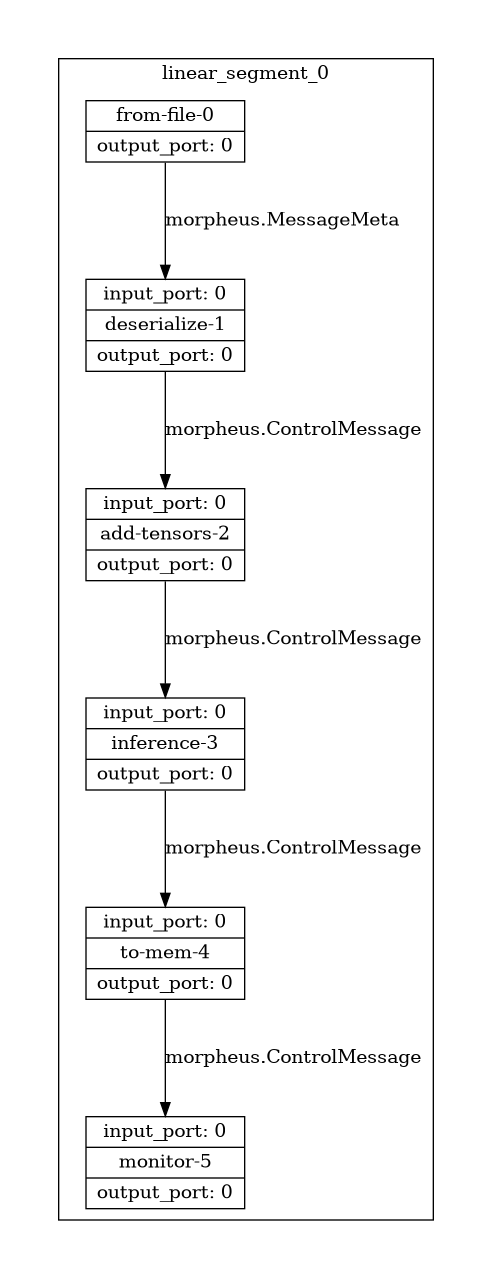

In [ ]:
Image(filename=viz_file)

In [ ]:
reset_logging()
configure_logging(log_level=logging.DEBUG)

====Starting Pipeline====
====Pipeline Started====
====Building Segment: linear_segment_0====
Added source: <from-file-0; FileSourceStage(filename=data/simple_user_log.jsonlines, iterative=False, file_type=FileTypes.Auto, repeat=100, filter_null=True, filter_null_columns=None, parser_kwargs=None)>
  └─> morpheus.MessageMeta


Added stage: <deserialize-1; DeserializeStage(ensure_sliceable_index=True, task_type=None, task_payload=None)>
  └─ morpheus.MessageMeta -> morpheus.ControlMessage


Added stage: <add-tensors-2; AddTensors()>
  └─ morpheus.ControlMessage -> morpheus.ControlMessage


Added stage: <inference-3; IdentityInferenceStage()>
  └─ morpheus.ControlMessage -> morpheus.ControlMessage


Added stage: <to-mem-4; InMemorySinkStage()>
  └─ morpheus.ControlMessage -> morpheus.ControlMessage


Added stage: <monitor-5; MonitorStage(description=Pipeline throughput, smoothing=0.05, unit=messages, delayed_start=False, determine_count_fn=None, log_level=LogLevels.INFO)>
  └─ morpheus.ControlMessage -> morpheus.ControlMessage


====Building Segment Complete!====


Pipeline throughput: 0 messages [00:00, ? messages/s]

====Pipeline Complete====


In [ ]:
# Run the pipeline
await pipeline.run_async()

Pipeline throughput[Complete]: 1000 messages [00:03, 303.14 messages/s]


In [ ]:
control_message = in_mem_sink.get_messages()[0]

In [ ]:
control_message.payload().get_data()

,timestamp,user,ip_address,request_time,status,error_message
0,2025-02-01T10:15:30Z,user123,192.168.1.10,200.45,success,<NA>
1,2025-02-01T10:17:00Z,user123,192.168.1.20,150.55,failure,Invalid credentials
2,2025-02-01T10:18:10Z,user456,10.0.0.5,180.60,success,<NA>
3,2025-02-01T10:19:25Z,user789,192.168.1.30,215.25,failure,Timeout
4,2025-02-01T10:20:00Z,user456,10.0.0.6,120.10,success,<NA>
5,2025-02-01T10:22:30Z,user123,192.168.1.40,175.35,failure,Access denied
6,2025-02-01T10:23:45Z,user321,192.168.1.50,205.50,success,<NA>
7,2025-02-01T10:25:05Z,user864,192.168.1.60,190.15,failure,Invalid session
8,2025-02-01T10:26:20Z,user123,192.168.1.70,210.80,success,<NA>
9,2025-02-01T10:27:40Z,user456,10.0.0.7,160.95,failure,Account locked


In [ ]:
tensors = control_message.tensors().get_tensors()

In [ ]:
tensors

{'probs': array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])}

In [ ]:
post_inference_tensors = tensors["probs"]

In [ ]:
post_inference_tensors.shape

(10, 6)